In [ ]:
# imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings


In [ ]:
path = 'C:\\Users\\Soham\\Desktop\\Insohamnia\\HRV\\Dataset\\Soham_Sahare\\2020_07_14_open.txt'
data = pd.read_csv(path,names=['RR'])
data.head()


,RR
0,702
1,340
2,554
3,447
4,554


In [ ]:
print('Data points -> {}'.format(len(data)))



Data points -> 877


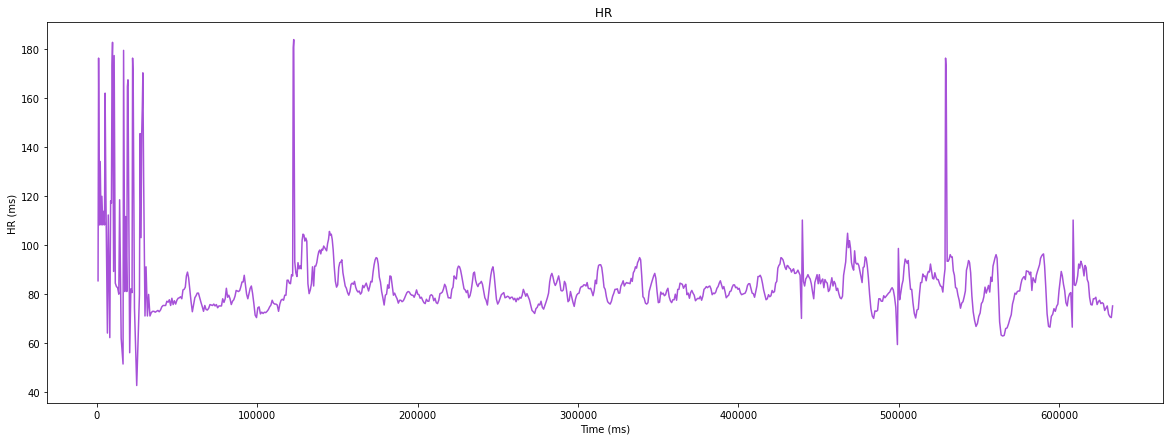

In [ ]:
# plot RR-intervals
plt.figure(figsize=(20, 7))
plt.title("HR ")
plt.xlabel("Time (ms)")
plt.ylabel("HR (ms)")

plt.plot(np.cumsum(data['RR']), data['RR'].apply(lambda x : 60000/x), label="RR-interval", color="#A651D8")
plt.show()



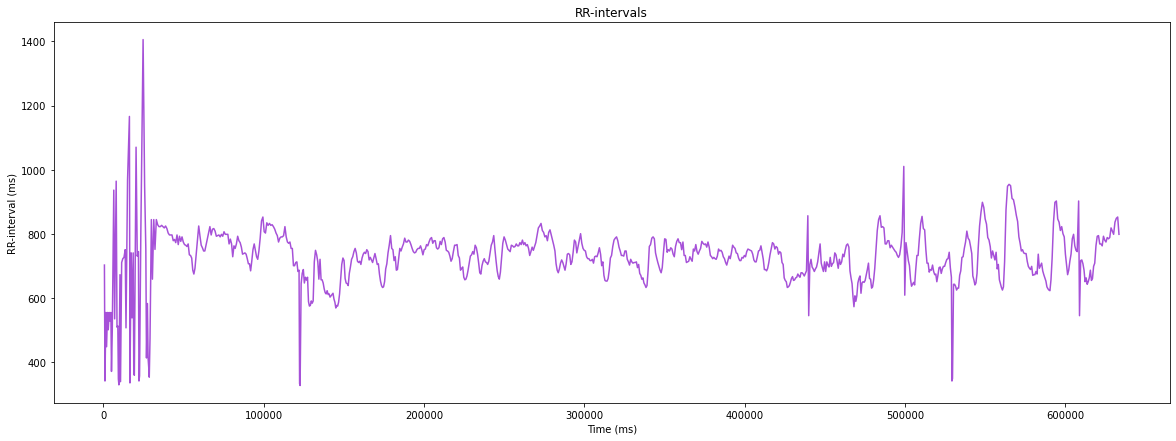

In [ ]:
# plot RR-intervals
plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(np.cumsum(data['RR']), data['RR'], label="RR-interval", color="#A651D8")
plt.show()



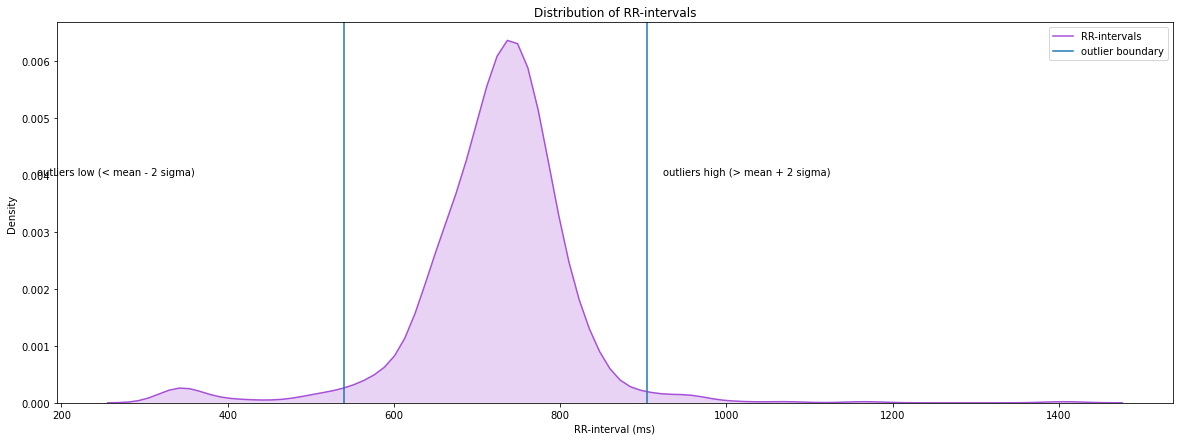

In [ ]:
rr = data['RR']
rr.head()


plt.figure(figsize=(20, 7))
plt.title("Distribution of RR-intervals")

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(rr, label="RR-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr) - 2 * np.std(rr)
outlier_high = np.mean(rr) + 2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 370, 0.004, "outliers low (< mean - 2 sigma)")
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)")

plt.xlabel("RR-interval (ms)")
plt.ylabel("Density")

plt.legend()
plt.show()



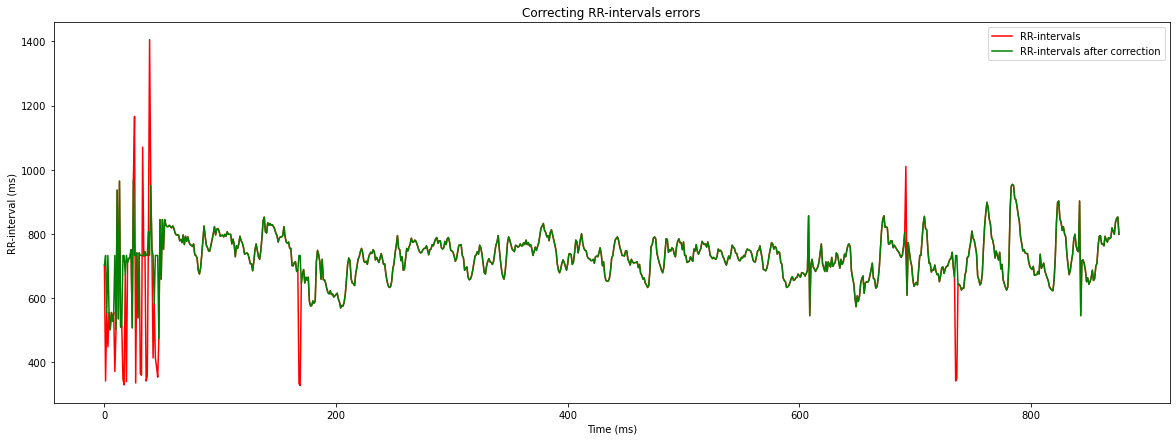

In [ ]:
plt.figure(figsize=(20, 7))

rr_corrected = rr.copy()
# rr_corrected = rr[np.abs(zscore(rr)<=2)]
rr_corrected[np.abs(zscore(rr)) > 3] = np.median(rr)

plt.title("Correcting RR-intervals errors")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(rr, color="red", label="RR-intervals")
plt.plot(rr_corrected, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()


# Time Domain Analysis

RMSSD is often used as the score that represents your “HRV”. It’s the most important one and it’s used in a lot of research. Here’s a list of other metrics, that are used for time domain analysis:

Mean RR: mean of RR-interval

SDNN: standard deviation of the RR-intervals

Mean HR: the well-known mean heartrate, measured in Beats Per Minute

STD HR: standard deviation of the heartrate

Min HR: lowest heartrate

Max HR: highest heartrate

NN50: The number of pairs of successive RR-intervals that differ by more than 50 ms. (normal RR-intervals are often called NN-intervals)

PNN50: The proportion of NN50 divided by the total number of pair of successive RR-intervals.


In [ ]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results


print("Time domain metrics - non corrected RR-intervals:")
for k, v in timedomain(rr).items():
    print("- %s: %.2f" % (k, v))

print('\n')

print("Time domain metrics - automatically corrected RR-intervals:")
for k, v in timedomain(rr_corrected).items():
    print("- %s: %.2f" % (k, v))


Time domain metrics - non corrected RR-intervals:
- Mean RR (ms): 722.17
- STD RR/SDNN (ms): 90.91
- Mean HR (Kubios' style) (beats/min): 83.08
- Mean HR (beats/min): 84.84
- STD HR (beats/min): 15.06
- Min HR (beats/min): 42.67
- Max HR (beats/min): 184.05
- RMSSD (ms): 84.32
- NNxx: 84.00
- pNNxx (%): 9.58


Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 728.28
- STD RR/SDNN (ms): 66.06
- Mean HR (Kubios' style) (beats/min): 82.39
- Mean HR (beats/min): 83.10
- STD HR (beats/min): 8.04
- Min HR (beats/min): 61.98
- Max HR (beats/min): 127.12
- RMSSD (ms): 55.35
- NNxx: 74.00
- pNNxx (%): 8.44


# Frequency Domain Analysis

Another approach for analysing heart rate variability is to study the power distribution in the frequency domain. It shows how much of signal lies within a certain frequency band. 
**High (HF) frequencies between 0.15–0.40 Hz are associated with Parasympathetic activity (recovery)** and **lower frequencies (LF) between 0.04–0.15 Hz are linked to both sympathetic and parasympathetic activity**. 
The **ratio of LF/HF is believed to be a measure for the Autonomic Nervous System balance**. 
A **higher HF and a lower LF/HF ratio** indicate an **increased HRV**, which means your body is recovering.

## Interpolation
We can’t just use the RR-intervals and do a Fourier Transform, because an FFT needs evenly sampled data. We can achieve this by interpolating the data. 
To interpolate, we first transform our list with RR-intervals to a time series where we arrange RR-intervals over time. To find the time points for each interval, we sum up the values of the RR-intervals. 
Next, we create an interpolation function that we can use to sample from with any resolution we want. We use a resolution of 4 samples per second. Now we can create an evenly spaced set of datapoints that we can use for the frequency analysis.


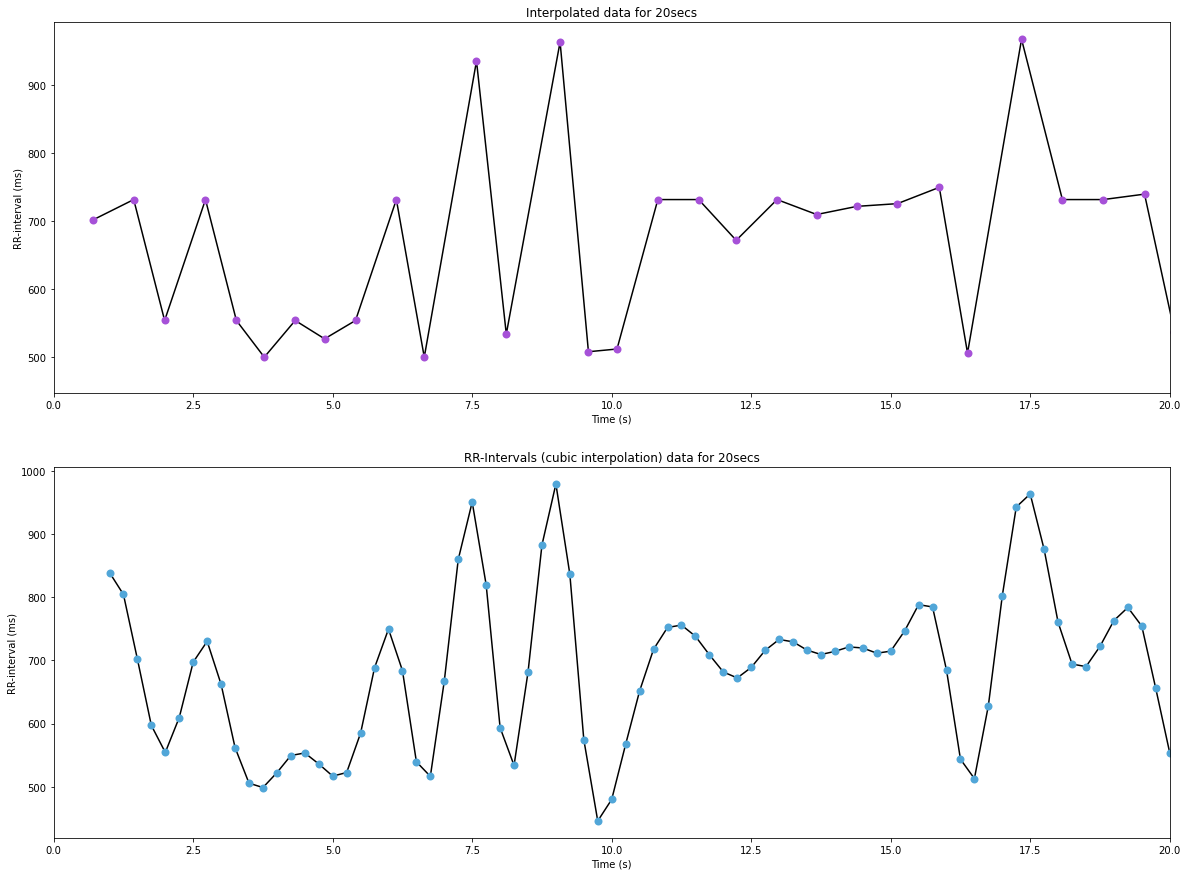

In [ ]:
# create interpolation function based on the rr-samples. 
x = np.cumsum(rr_corrected) / 1000.0
f = interp1d(x, rr_corrected, kind='cubic')

# sample rate for interpolation
fs = 4.0
steps = 1 / fs

# now we can sample from interpolation function
xx = np.arange(1, np.max(x), steps)
rr_interpolated = f(xx)


plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
plt.plot(x, rr_corrected, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated data for 20secs")
plt.gca().set_xlim(0, 20)

plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation) data for 20secs")
plt.plot(xx, rr_interpolated, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 20)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()


In [ ]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [ ]:
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(rr_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 832.28
- Power LF (ms2): 1177.19
- Power HF (ms2): 276.26
- Power Total (ms2): 2285.72
- LF/HF: 4.26
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.05
- Peak HF (Hz): 0.16
- Fraction LF (nu): 80.99
- Fraction HF (nu): 19.01


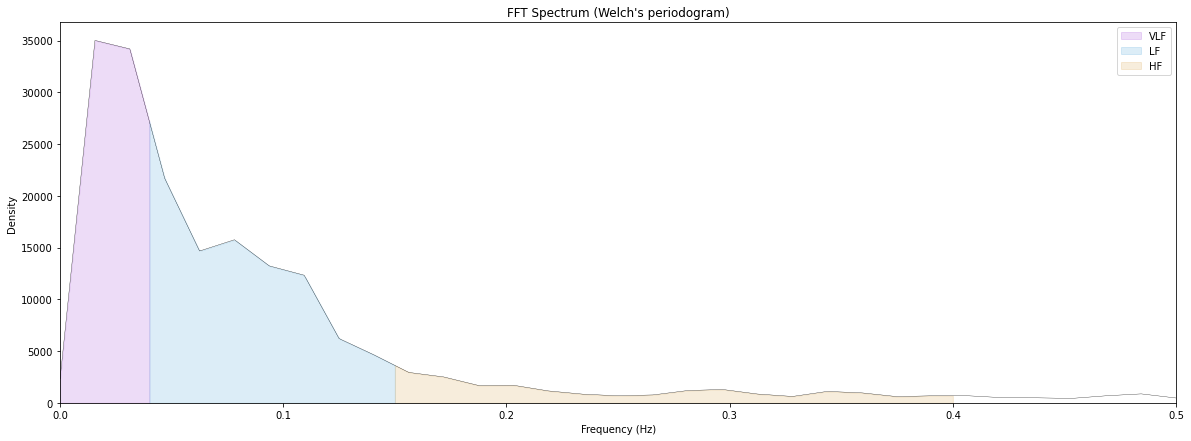

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(fxx, pxx, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Non linear methods
## Poincare plot
In Poincaré HRV each RR interval is plotted against the next RR interval. The resulting shape of the plot is the essential feature, and can be used to identify certain types of heart failures and illnesses.

In [ ]:
print(rr_corrected[0],rr_corrected[1])

702 732


In [ ]:
def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

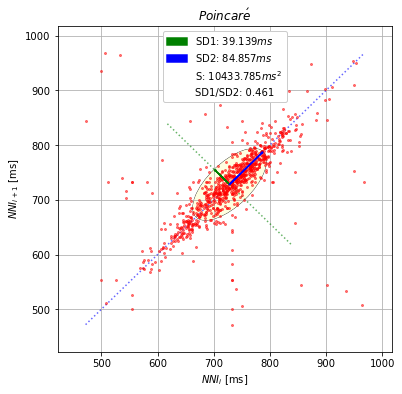

In [ ]:
import pyhrv.nonlinear as nl
result = nl.poincare(rr_corrected)

# References
https://www.kaggle.com/stetelepta/exploring-heart-rate-variability-using-python/notebook
